In [245]:
import cv2 as cv
from pdf2image import convert_from_path
import os
import matplotlib.pyplot as plt

In [8]:
def creation_images(dossier_destination, dossier_traitement):

    docs = os.listdir(dossier_traitement)
    name = "Document"
    compteur = 0

    for doc in docs:
        converted_doc = convert_from_path(os.path.join(dossier_traitement, doc))
        converted_doc[0].save(dossier_destination + "/" + name + " " + str(compteur) + ".jpeg", "JPEG")
        compteur+=1

creation_images("train", "../data/pdf/pdf with zoi")

In [625]:
import imutils

In [696]:
import numpy as np

def decomposition_img(lien_img):
    img = cv.imread(lien_img)

    #Phase de transformation
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_blur = cv.blur(img_gray, (33,33), 0)
    ret, thresh = cv.threshold(img_blur, 220, 255, cv.THRESH_BINARY)
    img_canny = cv.Canny(thresh,125,175)
    dilated = cv.dilate(img_canny, (15,15), iterations=65)
    dilated_blur = cv.blur(dilated, (15,15))

    #Détection des contours
    contours, hierarchies = cv.findContours(dilated_blur, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)

    list_img = []
    for idx in range(len(contours[:20])):

        mask = np.zeros_like(img) # Create mask where white is what we want, black otherwise
        cv.drawContours(mask, contours, idx, 255, -1) # Draw filled contour in mask
        out = np.zeros_like(img) # Extract out the object and place into output image
        out[mask == 255] = img[mask == 255]

        # Now crop
        y, x, _ = np.where(mask == 255)
        (topy, topx) = (np.min(y), np.min(x))
        (bottomy, bottomx) = (np.max(y), np.max(x))

        if(bottomy - topy > 30) and (bottomx - topx > 30):

            blank = np.zeros(img.shape[:2], dtype='uint8')
            rectangle = cv.rectangle(blank.copy(), (topx, topy), (bottomx, bottomy), 255, -1)
            out = cv.bitwise_and(img,img, mask=rectangle)
            out = out[topy:bottomy+1, topx:bottomx+1]
            img_gray_out = cv.cvtColor(out, cv.COLOR_BGR2GRAY)
            list_img.append(img_gray_out)
    
    return list_img

lili_res = decomposition_img('train/Document 16.jpeg')

In [697]:
import pytesseract, re
from PIL import Image

def image_to_csv_tesseract(dossier_traitement, label):

    csv_str = "Text;nbcaracteres;label\n"
    docs = os.listdir(dossier_traitement)

    for doc in docs:
        text = pytesseract.image_to_string(Image.open(os.path.join(dossier_traitement, doc)))
        text = re.sub(r"\s+", " ", text)
        text = re.sub(r";+", "", text)
        csv_str += f"{text};{len(text)};{label}\n"
    
    return csv_str

In [698]:
pytesseract.image_to_string(lili_res[10])

' \n\nVALID.\nVALID\nICURTAILE!\nVALID\nISUPERCH/\nICURTAILE!\nISUPERCH/\nISUPERCH/\nVALID\n\nVALID\n\nVALID\nVALID.\n\x0c'

20


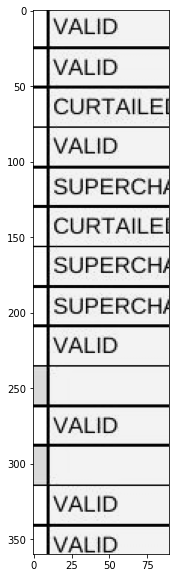

In [699]:
print(len(lili_res))
plt.figure(figsize = (10,10))
plt.imshow(lili_res[10], cmap='gray')

## Projet Mannathan

In [702]:
from google.cloud import storage

In [704]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/virgaux/IA_PAU_2022/iapau-3afbf-firebase-adminsdk-oag2r-2368a91e22.json"

def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"

    # The ID of your GCS object
    # source_blob_name = "storage-object-name"

    # The path to which the file should be downloaded
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    # Construct a client side representation of a blob.
    # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
    # any content from Google Cloud Storage. As we don't need additional data,
    # using `Bucket.blob` is preferred here.
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Downloaded storage object {} from bucket {} to local file {}.".format(
            source_blob_name, bucket_name, destination_file_name
        )
    )

In [705]:
download_blob('iapau-3afbf.appspot.com', 'zoi_1.pdf', 'mon_pdf.pdf')

Downloaded storage object zoi_1.pdf from bucket iapau-3afbf.appspot.com to local file mon_pdf.pdf.


In [707]:
from google.cloud import storage

def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    # bucket_name = "your-bucket-name"
    contenu = []
    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)

    for blob in blobs:
        contenu.append(blob.name)
    return contenu
list_blobs('iapau-3afbf.appspot.com')

['zoi_1.pdf']